<img src="img/banner.png" width = 90%>


## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

Projet de mise en place d'un système de classification binaire permettant de détecter des cas de pneumonie à partir de radios thoraciques, via utilisation d'un *modèle de vision par ordinateur préentraîné* type *CNN*. Utilisation du dataset *Chest X-Ray Pneumonia*.

Appréhension d'une démarche de suivi des expérimentations par *MLflow*, afin de tracer les paramètres d’entraînement, les métriques de performance et les versions de modèle.

**Contexte du projet** : Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.

_______________________________________________________________________________________________________________________________________________________

### Import des bibliothèques

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import mlflow
import mlflow.keras
import random

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


#from tensorflow.keras.applications import DenseNet121   # DenseNet121 = modèle très utilisé dans le domaine médical pour la détection
                                                        # de maladies pulmonaires. Testé, mais très lourd sur le processeur.

from tensorflow.keras.applications import MobileNetV3Large  # MobileNetV3 = modèle CNN plus général, mais plus léger
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input     # fonction préconisée pour la normalisation des données avec MobileNetV3


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

# 1. Exploration des données

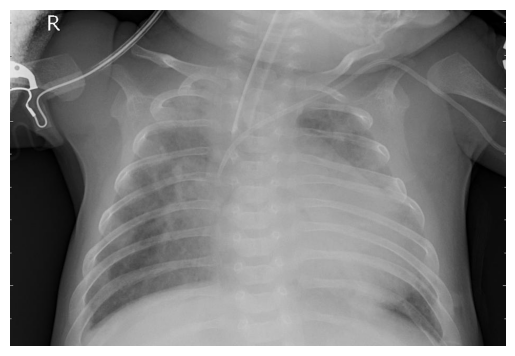

Shape (dimensions) : (640, 944, 3)
Type des valeurs : uint8


In [2]:
img = cv2.imread("data/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_COLOR_RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Shape (dimensions) : {img.shape}")
print(f"Type des valeurs : {img.dtype}")

En testant l'affichage de plusieurs images et leurs dimensions, nous pouvons voir que les radios sont de formats différents.

_______________________________________________________________________________________________________________________________________________________

# 2. Préparation des données et préprocessing

**MobileNetV3Large et ImageDataGenerator :**
 
- Plus le format d'image est grand, plus il sera performant.
- Nous créons un **ImageDataGenerator**, qui permettra de prétraiter et normaliser nos images pour le modèle, ainsi que de faire de la Data Augmentation (rotation, zoom, miroir, etc.) pour éviter l'overfitting. (*Normalement, cela permet également de charger nos images depuis les dossier afin d'éviter de tout charger en mémoire, et de les redimensionner. J'ai cependant fait le choix ici de le faire par la fonction get_train_test() afin de pouvoir filtrer les images illisibles sans les supprimer.*)
- Utilisation de la fonction **preprocess_input** dédiée à la normalisation des données pour MobileNetV3.
\
\
*A noter : ici les données sont au préalable séparées en dossiers test, train, et val pour faciliter le travail.*


In [3]:
def resize_with_padding(img, target_size = (224, 224, 3)):
        """ Fonction permettant de redimensionner les images à la même taille tout en gardant leur ratio,
            en ajoutant un padding noir quand nécessaire.        
        """
        
        h, w = img.shape[:2]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(img, (new_w, new_h))

        padded = np.zeros(target_size, dtype=np.uint8)

        y_offset = (target_size[0] - new_h) // 2
        x_offset = (target_size[1] - new_w) // 2

        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return padded

In [4]:
def get_train_test(base_path: str):
    """ Fonction parcourant les dossiers de nos datas afin de les charger et les séparer en deux tableaux Numpy (X pour les images,
        y pour les labels), et vérifiant si l'image est lisible ou non. Appel la fonction resize_with_padding afin de les redimensionner.
    """
    
    X = [] # images
    y = [] # labels
    label_to_int = {"NORMAL" : 0, "PNEUMONIA" : 1}

    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is None:
                print("Image illisible : ", file_path)
                continue
            img = resize_with_padding(img)
            X.append(img)
            y.append(label_to_int[label])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

Création des datagen avec ImageDataGenerator :

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Création de nos différents sets de données :

In [6]:
X_train, y_train = get_train_test("data/train")
X_test, y_test = get_train_test("data/test")
X_val, y_val = get_train_test("data/val")

X_test_display = X_test.copy()      # pour garder une copie de l'image d'origine afin de l'afficher lors de la prédiction

Application des datagen :

In [7]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
valid_generator = datagen.flow(X_val, y_val, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

Visualisation des 10 premières radios pour vérifier le fonctionnement du traitement précédent.

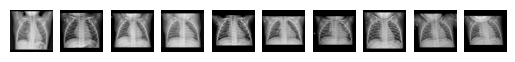

In [8]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

plt.show()

Rééquilibre des classes afin d'améliorer l'apprentissage. Evite au modèle de favoriser les classes majoritaires.

In [9]:
def compute_class_weights(y):
    """ Fonction permettant de calculer le poids des classes afin de les rééquilibrer    
    """
    
    # Calculer les poids de classe
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',    # equilibre automatiquement selon la fréquence
        classes=np.unique(y),       # classes présentes
        y=y)    # vecteur des labels
    
    # Créer un dictionnaire de poids
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict


In [10]:
# Utilisation de la fonction pour calculer les poids des classes sur nos données
class_weights = compute_class_weights(y_train)

_______________________________________________________________________________________________________________________________________________________

# 3. Modélisation

### a. Importation du modèle, paramétrage, et compilation

Nous créons le modèle sur la base du modèle pré-entraîné **MobileNetV3Large**, modèle CNN performant sur la classification d'images.\
Nous importons le modèle avec ses *poids pré-entraînés* (*ImageNet*). Avant cela nous normalisons les données avec la fonction dédiée *preprocess_input*.\
Nous n'utilisons pas la dernière couche du modèle (*include-top = False*) afin d'ajouter celles qui nous intéressent pour le résultat que nous recherché (*model_outputs*).

__DenseNet121__, précedemment testé, est très utilisé dans le domaine médical notamment dans la détection de maladie pulmonaires, mais il demande beaucoup de performances au processeur pour faire ses calculs. Malgré des résultats moins élevés, j'utilise un modèle plus léger pour raisons pédagogiques. Pour sa préparation :
- Les images devaient être redimensionnées au format *224 x 224*.
- Nous convertissons le format *int* des pixels de nos images en *float32*, pour ensuite normaliser nos données en les divisant par 255 (pour passer la valeur des pixels entre 0 et 1)
- Nous l'importions également avec les poids *ImageNet*, et les données étaient normalisées avec une certaine moyenne et un certain écart-type, les mêmes que lors de l'entraînement initial du modèle.

In [11]:
# choix des paramètres de compilation

optimizer = 'adam'
loss_function = 'binary_crossentropy'

In [12]:

inputs = Input(shape=(224, 224, 3))

# Importation du modèle avec les poids pré-entraîné d'ImageNet, et en excluant la dernière couche (include-top=False) pour ajouter la notre
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=inputs)

# Gel des couches du modèle pré-entraîné
base_model.trainable = False

# Création des couches hautes
model_outputs = base_model.output
model_outputs = GlobalAveragePooling2D()(model_outputs)
model_outputs = Dense(1, activation='sigmoid')(model_outputs)

# Création du modèle
model = Model(inputs=inputs, outputs = model_outputs)

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

Nous pouvons voir toutes les couches de notre modèle. Initialement, il ne prend pas en compte les paramètres des couches gelées.

In [13]:
# model.summary()

_______________________________________________________________________________________________________________________________________________________

# 4. Entraînement du modèle avec gel des couches basses

On définit un arrêt automatique pour éviter le surapprentissage, et réduire le temps d'entraînement inutile. Il servira également lors de l'entraînement suivant (avec plus de couches activées).

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)   # Surveillance pour empêcher le surapprentissage

nb_epochs = 10
batch_size = 32

### a. Entraînement

In [15]:
history_freeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

c:\Users\Utilisateur\Documents\PROJETS\02 - Transfer Learning\CNN_Transfer_Learning\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 498ms/step - accuracy: 0.7720 - loss: 0.4498 - val_accuracy: 0.7500 - val_loss: 0.7008
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.9014 - loss: 0.2229 - val_accuracy: 0.8750 - val_loss: 0.3138
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.9175 - loss: 0.1928 - val_accuracy: 0.7500 - val_loss: 0.4746
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9389 - loss: 0.1676 - val_accuracy: 0.8125 - val_loss: 0.2974
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9380 - loss: 0.1702 - val_accuracy: 0.8750 - val_loss: 0.2562
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.9391 - loss: 0.1540 - val_accuracy: 0.8125 - val_loss: 0.3560
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 461ms/step - accuracy: 0.9508 - loss: 0.1277 - val_accuracy: 0.8750 - val_loss: 0.4342
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 480ms/step - accuracy: 0.9519 - loss: 0

### b. Evaluation de la précision

In [16]:
loss_freeze, accuracy_freeze = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy_freeze*100:.2f}%")
print(f"Pertes : {loss_freeze}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.9100 - loss: 0.2373
Précision : 90.87%
Pertes : 0.2432945966720581


_______________________________________________________________________________________________________________________________________________________

# 5. Entraînement du modèle avec ajout de couches du modèle de base

Après avoir entraîné les dernières couches du modèle (que nous avons ajouté spécifiquement pour notre projet = outputs), nous dégelons quelques unes des dernières couches afin d'essayer d'optimiser au mieux les performances du modèle.

\
(Avec **DenseNet121** il était difficilement possible d'ajouter des couches pour l'optimisation, en raison d'un manque de performances de l'ordinateur.)

### a. Modélisation

In [17]:
for layer in base_model.layers[-10:]:   # ici nous dégelons les 10 dernières couches
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

In [18]:
#model.summary()

### c. Entraînement

In [19]:
history_nofreeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 522ms/step - accuracy: 0.9395 - loss: 0.1622 - val_accuracy: 0.9375 - val_loss: 0.2704
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 513ms/step - accuracy: 0.9582 - loss: 0.0949 - val_accuracy: 0.9375 - val_loss: 0.1027
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.9726 - loss: 0.0710 - val_accuracy: 0.9375 - val_loss: 0.2926
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 559ms/step - accuracy: 0.9708 - loss: 0.0784 - val_accuracy: 0.9375 - val_loss: 0.4452
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.9712 - loss: 0.0703 - val_accuracy: 0.7500 - val_loss: 0.9155


### d. Evaluation de la précision

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy*100:.2f}%")
print(f"Pertes : {loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.9219 - loss: 0.2455
Précision : 90.22%
Pertes : 0.26006144285202026


### e. Matrice de confusion

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step
Classification Report :

              precision    recall  f1-score   support

      Normal       0.84      0.91      0.88       234
   Pneumonia       0.95      0.89      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624



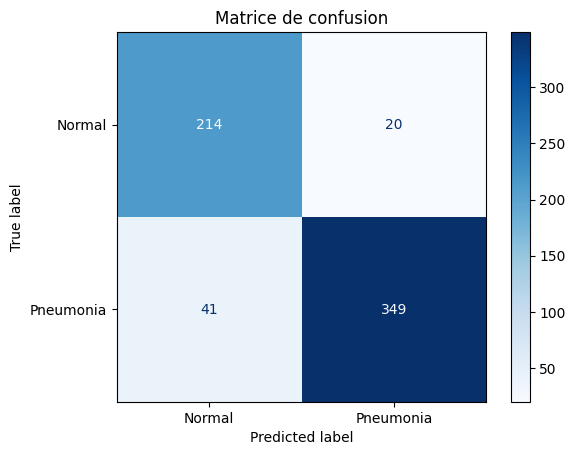

In [21]:
y_pred_proba = model.predict(X_test)

y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

print("Classification Report :\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


### f. Courbe ROC

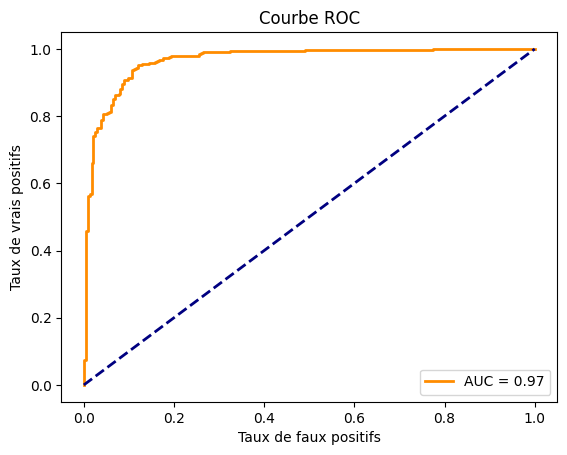

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

Nous pouvons voir grâce à ces différentes méthodes d'évaluation que notre modèle montre une efficacité plutôt convaincante :
- Accuracy d'environ 90%
- Loss proche de 0.26
- Recall d'environ 0.90
- Matrice de confusion avec une bonne répartition
- Belle courbe ROC
- AUC de 0.97

### g. Courbe de vérification de l'overfitting

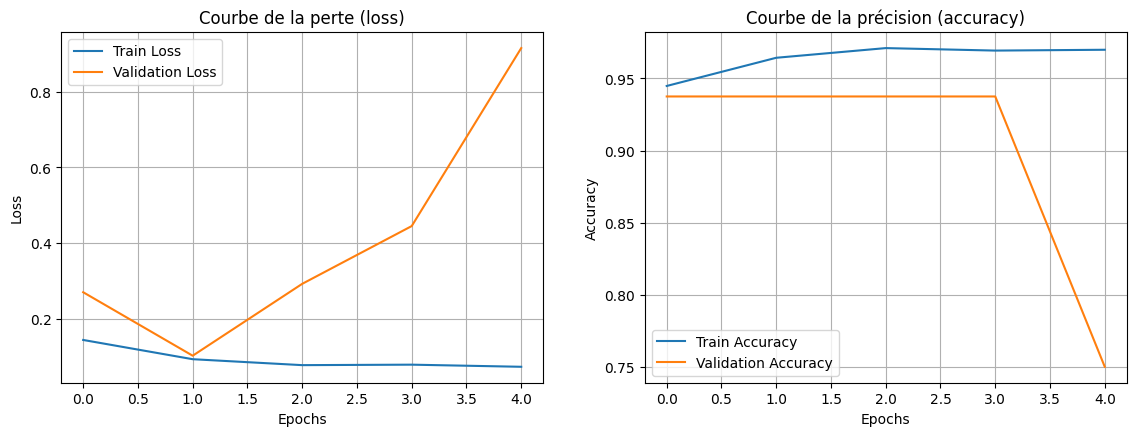

In [23]:
plt.figure(figsize=(12, 5))

# Courbe de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history_nofreeze.history['loss'], label='Train Loss')
plt.plot(history_nofreeze.history['val_loss'], label='Validation Loss')
plt.title('Courbe de la perte (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_nofreeze.history['accuracy'], label='Train Accuracy')
plt.plot(history_nofreeze.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de la précision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(pad=3.0)

plt.show()

Grâce à ces courbes nous pouvons surveiller si le modèle entre en overfitting ou non. Le EarlyStop ajouté précédemment est censé l'empêcher, c'est pourquoi nos graphique ont l'air si peu pertinent et sont étalés sur si peu d'epochs (arrêt automatique), et restaure automatiquement l'étape d'entraînement qui avait le meilleur résultat.

_______________________________________________________________________________________________________________________________________________________

# 6. Prédiction

Test de l'efficacité de notre modèle par prédiction. Une image est sélectionnée aléatoirement à chaque exécution.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


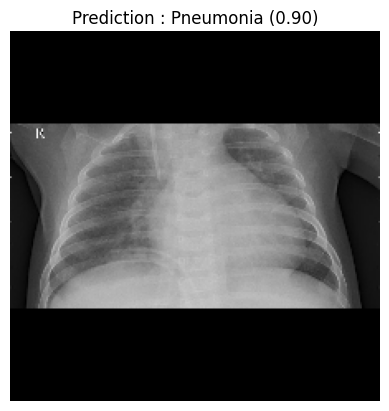

In [24]:
# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choix aléatoire d'une image dans X_test
img_to_predict = random.randint(0, len(X_test) - 1)

# Obtenir la prédiction (proba)
proba = model.predict(X_test[[img_to_predict]])[0][0]

# Classer selon le seuil 0.5
predicted_class = int(proba > 0.5)

# Afficher l’image avec prédiction
plt.imshow(X_test_display[img_to_predict].astype(np.uint8))
plt.title(f"Prediction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()

_______________________________________________________________________________________________________________________________________________________

# 7. Mise en place du suivi MLFlow

Ici nous centralisons dans un dictionnaire les paramètres qui nous intéresse pour le suivi des expériences.

In [25]:
params = {
    "model": "MobileNetV3Large",
    "input_shape": (224, 224, 3),
    "batch_size": batch_size,
    "epochs": nb_epochs,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "early_stop_patience": early_stop.patience,
    "early_stop_monitor": early_stop.monitor,
    "early_stop_resto_best_weights": early_stop.restore_best_weights,
    "Two_phase_training": True
}

Nous suivons l'expérience sous le format "**Pneumonia detection** + nom du modèle utilisé".\
Nous enregistrons les *paramètres* utilisé en parcourant le dictionnaire dédié, ainsi que l'évaluation des différents métriques.\
Nous générons aussi des graphiques de suivi des *métriques de performance*, ainsi que la *matrice de confusion* et la courbe ROC, retrouvables dans l'onglet Artifacts de MLFlow.

In [26]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("Pneumonia detection - MobileNetV3Large (ImageDataGenerator)")

with mlflow.start_run(run_name="Pneumonia detection - MobileNetV3Large"):
    
    for name, value in params.items():
        mlflow.log_param(name, str(value))

    mlflow.log_metric("val_loss", loss)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)

    def graph_metrics(history, recall, precision, f1, name):
        """Fonction permettant d'enregistrer les graphiques représentant les différentes métriques
            et de l'envoyer vers le serveur local MLflow

        Args:
            history : historique des évaluations du modèle
            recall : évaluation du recall du modèle
            precision : évaluation de l'accuracy
            f1 : évaluation du f1-score
            name (string): nom du fichier
        """

        plt.figure(figsize=(14, 4))

        # Graphique précision (accuracy)
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        # Graphique pertes (loss)
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Bar plot des métriques
        plt.subplot(1, 3, 3)
        metrics = ['Recall', 'Precision', 'F1-score']
        values = [recall, precision, f1]
        colors = ['skyblue', 'lightgreen', 'salmon']
        bars = plt.bar(metrics, values, color=colors)
        plt.ylim(0, 1)
        plt.title("Validation Metrics")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

        # Sauvegarde et log des graphiques dans MLflow
        file_path = f"{name.replace(' ', '_')}_full_metrics.png"
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), file_path)
        plt.close()



    def log_confusion_and_roc(y_true, y_pred, y_proba, labels, filename="confusion_and_roc.png"):
        """
        Affiche et envoie sur MLflow la matrice de confusion et la courbe ROC dans une seule figure.

        Args:
            y_true : Valeurs réelles (0 ou 1)
            y_pred : Prédictions binaires (0 ou 1)
            y_proba : Probabilités prédites (entre 0 et 1)
            labels : Liste des labels (ex : ["Normal", "Pneumonia"])
            filename (str): Nom du fichier à logger dans MLflow
        """

        # Matrice de confusion
        cm = confusion_matrix(y_true, y_pred)

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        # Figure combinée
        plt.figure(figsize=(12, 5))

        # ====== Matrice de confusion ======
        plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Matrice de confusion")
        plt.colorbar()
        tick_marks = range(len(labels))
        plt.xticks(tick_marks, labels)
        plt.yticks(tick_marks, labels)
        plt.xlabel("Prédictions")
        plt.ylabel("Réel")
        for i in range(len(cm)):
            for j in range(len(cm[0])):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center", color="black")

        # ====== Courbe ROC ======
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend(loc="lower right")

        # Log sur MLflow
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), filename)
        plt.close()


    # Tracer et logger les graphes vers MLflow
    graph_metrics(history_nofreeze, recall, precision, f1, name="Results")
    log_confusion_and_roc(
    y_true=y_test,
    y_pred=y_pred,
    y_proba=y_pred_proba,
    labels=["Normal", "Pneumonia"]
)

    # ==============================
    # 4. Logger le modèle final
    # ==============================
    mlflow.keras.log_model(model, "MobileNetV3Small")


2025/05/28 09:34:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/28 09:35:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Pneumonia detection - MobileNetV3Large at: http://127.0.0.1:5000/#/experiments/740987016087741830/runs/162777dff3064e10b087d75d43044c66
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/740987016087741830


Finalement, nous demandons à l'utilisateur si il veut enregistrer ce modèle (ou un autre). Cela nécessite d'indiquer l'ID de l'expérience associée.

In [27]:
while True:
   register_model = input("Voulez vous enregistrer un modèle ? (y/n)")
   if register_model == "y":
      run_id = input("Indiquez l'id du modèle :")
      model_uri = f'runs:/{run_id}/{params["model"]}'
      result = mlflow.register_model(
         model_uri, params["model"]
      )
   else:
      break

Nous pouvons donc plus tard charger un modèle pour le réutiliser.\
Exemple avec le chargement d'un modèle basé sur la version *Small* de *MobileNetV3* :

In [37]:
# Chargement du modèle

model_name = "MobileNetV3Small"
model_version = 3
model_uri = f"models:/{model_name}/{model_version}"
# Possible également de récupérer le modèle grâce à son alias :
# model_uri = f"models:/{model_name}@champion"

loaded_model = mlflow.keras.load_model(model_uri)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


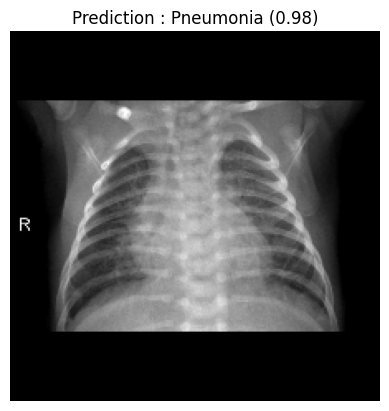

In [38]:
# Affichage de la prédiction

label_name = {0: "Normal", 1: "Pneumonia"}
img_to_predict = random.randint(0, len(X_test) - 1)

proba = loaded_model.predict(X_test[[img_to_predict]])[0][0]
predicted_class = int(proba > 0.5)

plt.imshow(X_test_display[img_to_predict].astype(np.uint8))
plt.title(f"Prediction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()

Le chargement du modèle s'exécute parfaitement, et la prédiction est faite.

# 8. Quelles améliorations ?

Le projet pourrait être amélioré de plusieurs façons :
- Nettoyage et augmentation des données plus poussés.
- En utilisant DenseNet121 comme base du modèle, algorithme plus lourd mais plus performant dans notre cas.
- Potentiel test d'autres architectures CNN comme EfficientNet ou ResNet par exemple.
- Amélioration des paramètres grâce à l'utilisation de GridSearchCV, qui définirait les paramètres les plus performants pour notre modèle.
- Optimisation plus pointilleuse de la phase d'entraînement et fine-tuning plus progressif, afin d'augmenter la précision, diminuer les pertes, et améliorer le Recall.
- Un suivi MLflow plus complet.